In [43]:
import sys
import pandas as pd
import datatable as dt
import numpy as np
from multiprocessing import Pool
from copy import deepcopy

PATH = "/home/jmurga/mkt/202004" 
sys.path.insert(0, PATH + '/scripts/src/')  
from py_amkt import *
from slim_parser import *

In [12]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [13]:
%%R
plot_simulated_alphas = function(df,output){

	if(length(unique(df$alpha_weak)) > 1){
	    df$alpha_weak = factor(df$alpha_weak, labels = c("alpha[w]:0.1","alpha[w]:0.2","alpha[w]:0.3"))
	}else{
	    df$alpha_weak = factor(df$alpha_weak, labels = c("alpha[w]:0.1"))
	}	
	if(length(unique(df$B)) > 1){
	    df$B = factor(df$B, labels = c("B:0.2","B:0.4","B:0.8","B:0.999"))
	}else{
	    df$B = factor(df$B, labels = c("B:0.999"))
	}

	p = ggplot(df, aes(x=f,y=alphas,color=sfs)) + 
	    geom_line() + 
	    # geom_hline(data=trues,aes(yintercept=trueAlpha),color = 'gray',linetype = "dotted", size = 1) +
	    facet_grid(B~alpha_weak,labeller=label_parsed) + 
	    ylim(-0.5,0.5) + 
	    scale_color_manual(values=c('black','#ab2710'),name = "SFS", labels = c("All alleles","Neutral + deleterious")) + 
	    theme_bw() + 
	    ylab(expression(alpha)) + 
	    xlab('Derived Allele Count') + 
	    theme(legend.position="bottom",legend.text=element_text(size=14),plot.title=element_text(hjust=0.5,face='bold'))

	ggsave(p,filename=output,dpi=600)
    
    return(p)
}

Create the output directory. You should change the directory tree if you clone the github repo

In [4]:
!mkdir -p /home/jmurga/mkt/202004/raw_data/simulations 

Add the proper packages to your Julia session

In [ ]:
!julia -e 'using Pkg;Pkg.add("CSV");Pkg.add("DataFrames");Pkg.add(PackageSpec(path="https://github.com/jmurga/MKtest.jl"))'

In [ ]:
!julia -e 'using Pkg;Pkg.add("CSV");Pkg.add("DataFrames");Pkg.add(PackageSpec(path="https://github.com/jmurga/MKtest.jl"))'

# No demography simulations

## Solving fixation probabilites and mutation rate to simulate with MKtest.jl

In [2]:
sim_table = pd.read_csv(PATH + "/raw_data/simulations/bgs_table_dup.tsv", sep='\t')
sim_table['path'] = sim_table.apply(lambda row: "/home/jmurga/mkt/202004/raw_data/simulations/no_demog/no_demog_" + str(row['alpha']) + "_" + str(row['alpha_weak']) + "_" + str(np.round(row['B'],4)),axis=1)
sim_table

,bgs_θ,ppos_l,ppos_h,alpha_weak,alpha,estimation,B,path
0,6.608754e-07,0.003878,0.000312,0.1,0.4,0.25695,0.200,/home/jmurga/mkt/202004/raw_data/simulations/n...
1,6.608754e-07,0.007741,0.000207,0.2,0.4,0.23094,0.200,/home/jmurga/mkt/202004/raw_data/simulations/n...
2,6.608754e-07,0.011589,0.000103,0.3,0.4,0.20293,0.200,/home/jmurga/mkt/202004/raw_data/simulations/n...
3,3.762519e-07,0.003878,0.000312,0.1,0.4,0.31316,0.400,/home/jmurga/mkt/202004/raw_data/simulations/n...
4,3.762519e-07,0.007741,0.000207,0.2,0.4,0.29547,0.400,/home/jmurga/mkt/202004/raw_data/simulations/n...
5,3.762519e-07,0.011589,0.000103,0.3,0.4,0.27677,0.400,/home/jmurga/mkt/202004/raw_data/simulations/n...
6,9.162832e-08,0.003878,0.000312,0.1,0.4,0.37854,0.800,/home/jmurga/mkt/202004/raw_data/simulations/n...
7,9.162832e-08,0.007741,0.000207,0.2,0.4,0.37436,0.800,/home/jmurga/mkt/202004/raw_data/simulations/n...
8,9.162832e-08,0.011589,0.000103,0.3,0.4,0.37010,0.800,/home/jmurga/mkt/202004/raw_data/simulations/n...
9,4.108304e-10,0.003878,0.000312,0.1,0.4,0.40136,0.999,/home/jmurga/mkt/202004/raw_data/simulations/n...


## Running SLiM

We run SLiM into and HPC enviroment due to the amount of replicas. Please copy outputs to the proper path after run the simulations. Here is the SLURM script:

```bash
#!/bin/bash

#SBATCH --partition=standard
#SBATCH --job-name=no_demog
#SBATCH --time=12:00:00
#SBATCH --mail-type=ALL
#SBATCH --mail-user=jesus.murga@uab.cat
#SBACTH --array=1-50000

DPATH="/xdisk/denard/mig2020/rsgrps/denard"

module load slim
module load parallel

# Each command takes about 12hours to run using this configuration

##########BGS 0.2

parallel -j200 -u "slim -d N=500 -d sampleSize=500 -d wS=10 -d sS=500 -d muBgs=6.608754e-07 -d pposL=0.003877 -d pposH=0.000311 -d nF={} -d output=\'${DPATH}/jmurga/simulations/no_demog/no_demog_0.4_0.1_0.2\' ${DPATH}/jmurga/src/bgs.slim" ::: `seq 1 50000`

parallel -j200 -u "slim -d N=500 -d sampleSize=500 -d wS=10 -d sS=500 -d muBgs=6.608754e-07 -d pposL=0.007739 -d pposH=0.000207 -d nF={} -d output=\'${DPATH}/jmurga/simulations/no_demog/no_demog_0.4_0.2_0.2\' ${DPATH}/jmurga/src/bgs.slim" ::: `seq 1 50000`

parallel -j200 -u "slim -d N=500 -d sampleSize=500 -d wS=10 -d sS=500 -d muBgs=6.608754e-07 -d pposL=0.011586 -d pposH=0.000103 -d nF={} -d output=\'${DPATH}/jmurga/simulations/no_demog/no_demog_0.4_0.3_0.2\' ${DPATH}/jmurga/src/bgs.slim" ::: `seq 1 50000`

##########BGS 0.4
parallel -j200 -u "slim -d N=500 -d sampleSize=500 -d wS=10 -d sS=500 -d muBgs=3.762519e-07 -d pposL=0.003877 -d pposH=0.000311 -d nF={} -d output=\'${DPATH}/jmurga/simulations/no_demog/no_demog_0.4_0.1_0.4\' ${DPATH}/jmurga/src/bgs.slim" ::: `seq 1 50000`

parallel -j200 -u "slim -d N=500 -d sampleSize=500 -d wS=10 -d sS=500 -d muBgs=3.762519e-07 -d pposL=0.007739 -d pposH=0.000207 -d nF={} -d output=\'${DPATH}/jmurga/simulations/no_demog/no_demog_0.4_0.2_0.4\' ${DPATH}/jmurga/src/bgs.slim" ::: `seq 1 50000`

parallel -j200 -u "slim -d N=500 -d sampleSize=500 -d wS=10 -d sS=500 -d muBgs=3.762519e-07 -d pposL=0.011586 -d pposH=0.000103 -d nF={} -d output=\'${DPATH}/jmurga/simulations/no_demog/no_demog_0.4_0.3_0.4\' ${DPATH}/jmurga/src/bgs.slim" ::: `seq 1 50000`

##########BGS 0.8
parallel -j200 -u "slim -d N=500 -d sampleSize=500 -d wS=10 -d sS=500 -d muBgs=9.162832e-08 -d pposL=0.003877 -d pposH=0.000311 -d nF={} -d output=\'${DPATH}/jmurga/simulations/no_demog/no_demog_0.4_0.1_0.8\' ${DPATH}/jmurga/src/bgs.slim" ::: `seq 1 50000`

parallel -j200 -u "slim -d N=500 -d sampleSize=500 -d wS=10 -d sS=500 -d muBgs=9.162832e-08 -d pposL=0.007739 -d pposH=0.000207 -d nF={} -d output=\'${DPATH}/jmurga/simulations/no_demog/no_demog_0.4_0.2_0.8\' ${DPATH}/jmurga/src/bgs.slim" ::: `seq 1 50000`

parallel -j200 -u "slim -d N=500 -d sampleSize=500 -d wS=10 -d sS=500 -d muBgs=9.162832e-08 -d pposL=0.011586 -d pposH=0.000103 -d nF={} -d output=\'${DPATH}/jmurga/simulations/no_demog/no_demog_0.4_0.3_0.8\' ${DPATH}/jmurga/src/bgs.slim" ::: `seq 1 50000`

##########BGS 0.999
parallel -j200 -u "slim -d N=500 -d sampleSize=500 -d wS=10 -d sS=500 -d muBgs=4.108304e-10 -d pposL=0.003877 -d pposH=0.000311 -d nF={} -d output=\'${DPATH}/jmurga/simulations/no_demog/no_demog_0.4_0.1_0.999\' ${DPATH}/jmurga/src/bgs.slim" ::: `seq 1 50000`

parallel -j200 -u "slim -d N=500 -d sampleSize=500 -d wS=10 -d sS=500 -d muBgs=4.108304e-10 -d pposL=0.007739 -d pposH=0.000207 -d nF={} -d output=\'${DPATH}/jmurga/simulations/no_demog/no_demog_0.4_0.2_0.999\' ${DPATH}/jmurga/src/bgs.slim" ::: `seq 1 50000`

parallel -j200 -u "slim -d N=500 -d sampleSize=500 -d wS=10 -d sS=500 -d muBgs=4.108304e-10 -d pposL=0.011586 -d pposH=0.000103 -d nF={} -d output=\'${DPATH}/jmurga/simulations/no_demog/no_demog_0.4_0.3_0.999\' ${DPATH}/jmurga/src/bgs.slim" ::: `seq 1 50000`

```

## Processing simulated data

In [5]:
sim_table

,bgs_θ,ppos_l,ppos_h,alpha_weak,alpha,estimation,B,path
0,6.608754e-07,0.003878,0.000312,0.1,0.4,0.25695,0.200,/home/jmurga/mkt/202004/raw_data/simulations/n...
1,6.608754e-07,0.007741,0.000207,0.2,0.4,0.23094,0.200,/home/jmurga/mkt/202004/raw_data/simulations/n...
2,6.608754e-07,0.011589,0.000103,0.3,0.4,0.20293,0.200,/home/jmurga/mkt/202004/raw_data/simulations/n...
3,3.762519e-07,0.003878,0.000312,0.1,0.4,0.31316,0.400,/home/jmurga/mkt/202004/raw_data/simulations/n...
4,3.762519e-07,0.007741,0.000207,0.2,0.4,0.29547,0.400,/home/jmurga/mkt/202004/raw_data/simulations/n...
5,3.762519e-07,0.011589,0.000103,0.3,0.4,0.27677,0.400,/home/jmurga/mkt/202004/raw_data/simulations/n...
6,9.162832e-08,0.003878,0.000312,0.1,0.4,0.37854,0.800,/home/jmurga/mkt/202004/raw_data/simulations/n...
7,9.162832e-08,0.007741,0.000207,0.2,0.4,0.37436,0.800,/home/jmurga/mkt/202004/raw_data/simulations/n...
8,9.162832e-08,0.011589,0.000103,0.3,0.4,0.37010,0.800,/home/jmurga/mkt/202004/raw_data/simulations/n...
9,4.108304e-10,0.003878,0.000312,0.1,0.4,0.40136,0.999,/home/jmurga/mkt/202004/raw_data/simulations/n...


In [6]:
for index,row in sim_table.iterrows():
    print(row.path)
    parse_and_bootstrap(row.path,500,nthreads=20,replicas=100)

/home/jmurga/mkt/202004/raw_data/simulations/no_demog/no_demog_0.4_0.1_0.2


100%|████████████████████████████| 100/100 [01:36<00:00,  1.04it/s]


/home/jmurga/mkt/202004/raw_data/simulations/no_demog/no_demog_0.4_0.2_0.2


100%|████████████████████████████| 100/100 [01:35<00:00,  1.05it/s]


/home/jmurga/mkt/202004/raw_data/simulations/no_demog/no_demog_0.4_0.3_0.2


100%|████████████████████████████| 100/100 [01:35<00:00,  1.05it/s]


/home/jmurga/mkt/202004/raw_data/simulations/no_demog/no_demog_0.4_0.1_0.4


100%|████████████████████████████| 100/100 [01:34<00:00,  1.06it/s]


/home/jmurga/mkt/202004/raw_data/simulations/no_demog/no_demog_0.4_0.2_0.4


100%|████████████████████████████| 100/100 [01:36<00:00,  1.03it/s]


/home/jmurga/mkt/202004/raw_data/simulations/no_demog/no_demog_0.4_0.3_0.4


100%|████████████████████████████| 100/100 [01:37<00:00,  1.02it/s]


/home/jmurga/mkt/202004/raw_data/simulations/no_demog/no_demog_0.4_0.1_0.8


100%|████████████████████████████| 100/100 [01:38<00:00,  1.01it/s]


/home/jmurga/mkt/202004/raw_data/simulations/no_demog/no_demog_0.4_0.2_0.8


100%|████████████████████████████| 100/100 [01:36<00:00,  1.03it/s]


/home/jmurga/mkt/202004/raw_data/simulations/no_demog/no_demog_0.4_0.3_0.8


100%|████████████████████████████| 100/100 [01:31<00:00,  1.09it/s]


/home/jmurga/mkt/202004/raw_data/simulations/no_demog/no_demog_0.4_0.1_0.999


100%|████████████████████████████| 100/100 [01:36<00:00,  1.04it/s]


/home/jmurga/mkt/202004/raw_data/simulations/no_demog/no_demog_0.4_0.2_0.999


100%|████████████████████████████| 100/100 [01:34<00:00,  1.05it/s]


/home/jmurga/mkt/202004/raw_data/simulations/no_demog/no_demog_0.4_0.3_0.999


100%|████████████████████████████| 100/100 [01:36<00:00,  1.04it/s]


In [3]:
df,df_alpha = save_simulated_alphas(sim_table);
df_alpha

,f,alphas,B,alpha_weak,sfs,path
0,0.001001,-0.647849,0.200,0.1,Neutral + deleterious,no_demog_0.4_0.1_0.2
1,0.002002,-0.407424,0.200,0.1,Neutral + deleterious,no_demog_0.4_0.1_0.2
2,0.003003,-0.332796,0.200,0.1,Neutral + deleterious,no_demog_0.4_0.1_0.2
3,0.004004,-0.281825,0.200,0.1,Neutral + deleterious,no_demog_0.4_0.1_0.2
4,0.005005,-0.245331,0.200,0.1,Neutral + deleterious,no_demog_0.4_0.1_0.2
...,...,...,...,...,...,...
994,0.995996,0.066204,0.999,0.3,All alleles,no_demog_0.4_0.3_0.999
995,0.996997,0.084752,0.999,0.3,All alleles,no_demog_0.4_0.3_0.999
996,0.997998,0.106332,0.999,0.3,All alleles,no_demog_0.4_0.3_0.999
997,0.998999,0.035028,0.999,0.3,All alleles,no_demog_0.4_0.3_0.999


In [6]:
df = df.round(3)
df_alpha = df_alpha.round(3)

In [42]:
df.to_csv(PATH + '/results/simulations/slim/no_demog/simulated_alphas.tsv',index=False,sep='\t',header=True)

In [43]:
df_alpha.to_csv(PATH + '/results/simulations/slim/no_demog/simulated_to_plot_all.tsv',index=False,sep='\t',header=True)

In [7]:
df_alpha['path'] = pd.Categorical(df_alpha['path'], ["no_demog_0.4_0.1_0.2","no_demog_0.4_0.2_0.2","no_demog_0.4_0.3_0.2","no_demog_0.4_0.1_0.4","no_demog_0.4_0.2_0.4","no_demog_0.4_0.3_0.4","no_demog_0.4_0.1_0.8","no_demog_0.4_0.2_0.8","no_demog_0.4_0.3_0.8","no_demog_0.4_0.1_0.999","no_demog_0.4_0.2_0.999","no_demog_0.4_0.3_0.999"])

In [46]:
df_alpha = pd.read_csv(PATH + '/results/simulations/slim/no_demog/simulated_to_plot_all.tsv',sep='\t')

/home/jmurga/.mamba/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '
R[write to console]: Saving 6.67 x 6.67 in image

R[write to console]: Saving 6.67 x 6.67 in image

R[write to console]: Saving 6.67 x 6.67 in image



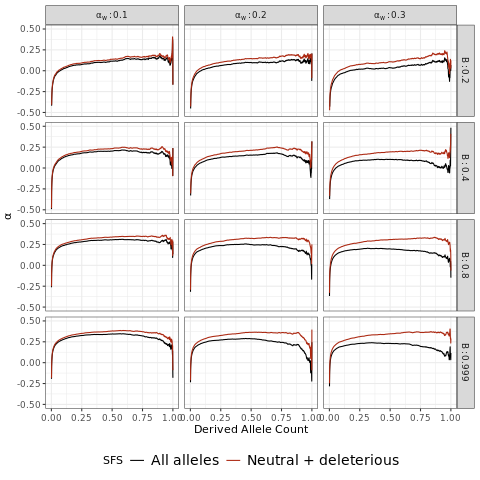

In [7]:
%%R -i PATH -i df_alpha 
p = plot_simulated_alphas(df = df_alpha,output = paste0(PATH,"/results/simulations/slim/no_demog/simulated_alphas_dup.svg"))
p = plot_simulated_alphas(df = df_alpha,output = paste0(PATH,"/results/simulations/slim/no_demog/simulated_alphas_dup.pdf"))
p = plot_simulated_alphas(df = df_alpha,output = paste0(PATH,"/results/simulations/slim/no_demog/simulated_alphas_dup.png"))

p

# Tennesen model

## Solving fixantion probabilites to simulate with MKtest.jl

In [ ]:
!julia /home/jmurga/mkt/202004/scripts/src/sim_table.jl 7310 661 200000 tennesen

In [51]:
sim_table = pd.read_csv(PATH + "/raw_data/simulations/tennesen.tsv", sep='\t')
sim_table['path'] = sim_table.apply(lambda row: "/home/jmurga/mkt/202004/raw_data/simulations/isolation/isolation_" + str(row['alpha']) + "_" + str(row['alpha_weak']) + "_" + str(np.round(row['B'],4)),axis=1)
sim_table

,bgs_θ,ppos_l,ppos_h,alpha_weak,alpha,estimation,B,path
0,9.040704e-08,0.003860,0.000239,0.1,0.4,0.25688,0.200,/home/jmurga/mkt/202004/raw_data/simulations/i...
1,9.040704e-08,0.007705,0.000159,0.2,0.4,0.23086,0.200,/home/jmurga/mkt/202004/raw_data/simulations/i...
2,9.040704e-08,0.011536,0.000079,0.3,0.4,0.20285,0.200,/home/jmurga/mkt/202004/raw_data/simulations/i...
3,5.147085e-08,0.003860,0.000239,0.1,0.4,0.31311,0.400,/home/jmurga/mkt/202004/raw_data/simulations/i...
4,5.147085e-08,0.007705,0.000159,0.2,0.4,0.29542,0.400,/home/jmurga/mkt/202004/raw_data/simulations/i...
5,5.147085e-08,0.011536,0.000079,0.3,0.4,0.27673,0.400,/home/jmurga/mkt/202004/raw_data/simulations/i...
6,1.253465e-08,0.003860,0.000239,0.1,0.4,0.37851,0.800,/home/jmurga/mkt/202004/raw_data/simulations/i...
7,1.253465e-08,0.007705,0.000159,0.2,0.4,0.37433,0.800,/home/jmurga/mkt/202004/raw_data/simulations/i...
8,1.253465e-08,0.011536,0.000079,0.3,0.4,0.37008,0.800,/home/jmurga/mkt/202004/raw_data/simulations/i...
9,5.620116e-11,0.003860,0.000239,0.1,0.4,0.40134,0.999,/home/jmurga/mkt/202004/raw_data/simulations/i...


## Running SLiM

We run SLiM into and HPC enviroment due to the amount of replicas. Please copy outputs to the proper path after run the simulations. Here is the SLURM script:

```bash
#!/bin/bash

#SBATCH --partition=standard
#SBATCH --job-name=isolation
#SBATCH --time=12:00:00
#SBATCH --mail-type=ALL
#SBATCH --mail-user=jesus.murga@uab.cat
#SBACTH --array=1-50000

DPATH="/xdisk/denard/mig2020/rsgrps/denard"

module load slim
module load parallel

# Each command takes about 12hours to run using this configuration

##########BGS 0.2

parallel -j200 -u "slim -d N=7310 -d sampleSize=661 -d wS=10 -d sS=500 -d muBgs=9.040704e-08 -d pposL=0.003860 -d pposH=0.000239 -d nF={} -d output=\'${DPATH}/jmurga/simulations/no_demog/no_demog_0.4_0.1_0.2\' ${DPATH}/jmurga/src/bgs.slim" ::: `seq 1 50000`

parallel -j200 -u "slim -d N=7310 -d sampleSize=661 -d wS=10 -d sS=500 -d muBgs=9.040704e-08 -d pposL=0.007705 -d pposH=0.000159 -d nF={} -d output=\'${DPATH}/jmurga/simulations/no_demog/no_demog_0.4_0.2_0.2\' ${DPATH}/jmurga/src/bgs.slim" ::: `seq 1 50000`

parallel -j200 -u "slim -d N=7310 -d sampleSize=661 -d wS=10 -d sS=500 -d muBgs=9.040704e-08 -d pposL=0.011536 -d pposH=0.000079 -d nF={} -d output=\'${DPATH}/jmurga/simulations/no_demog/no_demog_0.4_0.3_0.2\' ${DPATH}/jmurga/src/bgs.slim" ::: `seq 1 50000`

##########BGS 0.4
parallel -j200 -u "slim -d N=7310 -d sampleSize=661 -d wS=10 -d sS=500 -d muBgs=5.147085e-08 -d pposL=0.003860 -d pposH=0.000239 -d nF={} -d output=\'${DPATH}/jmurga/simulations/no_demog/no_demog_0.4_0.1_0.4\' ${DPATH}/jmurga/src/bgs.slim" ::: `seq 1 50000`

parallel -j200 -u "slim -d N=7310 -d sampleSize=661 -d wS=10 -d sS=500 -d muBgs=5.147085e-08 -d pposL=0.007705 -d pposH=0.000159 -d nF={} -d output=\'${DPATH}/jmurga/simulations/no_demog/no_demog_0.4_0.2_0.4\' ${DPATH}/jmurga/src/bgs.slim" ::: `seq 1 50000`

parallel -j200 -u "slim -d N=7310 -d sampleSize=661 -d wS=10 -d sS=500 -d muBgs=5.147085e-08 -d pposL=0.011536 -d pposH=0.000079 -d nF={} -d output=\'${DPATH}/jmurga/simulations/no_demog/no_demog_0.4_0.3_0.4\' ${DPATH}/jmurga/src/bgs.slim" ::: `seq 1 50000`

##########BGS 0.8
parallel -j200 -u "slim -d N=7310 -d sampleSize=661 -d wS=10 -d sS=500 -d muBgs=1.253465e-08 -d pposL=0.003860 -d pposH=0.000239 -d nF={} -d output=\'${DPATH}/jmurga/simulations/no_demog/no_demog_0.4_0.1_0.8\' ${DPATH}/jmurga/src/bgs.slim" ::: `seq 1 50000`

parallel -j200 -u "slim -d N=7310 -d sampleSize=661 -d wS=10 -d sS=500 -d muBgs=1.253465e-08 -d pposL=0.007705 -d pposH=0.000159 -d nF={} -d output=\'${DPATH}/jmurga/simulations/no_demog/no_demog_0.4_0.2_0.8\' ${DPATH}/jmurga/src/bgs.slim" ::: `seq 1 50000`

parallel -j200 -u "slim -d N=7310 -d sampleSize=661 -d wS=10 -d sS=500 -d muBgs=1.253465e-08 -d pposL=0.011536 -d pposH=0.000079 -d nF={} -d output=\'${DPATH}/jmurga/simulations/no_demog/no_demog_0.4_0.3_0.8\' ${DPATH}/jmurga/src/bgs.slim" ::: `seq 1 50000`

##########BGS 0.999
parallel -j200 -u "slim -d N=7310 -d sampleSize=661 -d wS=10 -d sS=500 -d muBgs=5.620116e-11 -d pposL=0.003860 -d pposH=0.000239 -d nF={} -d output=\'${DPATH}/jmurga/simulations/no_demog/no_demog_0.4_0.1_0.999\' ${DPATH}/jmurga/src/bgs.slim" ::: `seq 1 50000`

parallel -j200 -u "slim -d N=7310 -d sampleSize=661 -d wS=10 -d sS=500 -d muBgs=5.620116e-11 -d pposL=0.007705 -d pposH=0.000159 -d nF={} -d output=\'${DPATH}/jmurga/simulations/no_demog/no_demog_0.4_0.2_0.999\' ${DPATH}/jmurga/src/bgs.slim" ::: `seq 1 50000`

parallel -j200 -u "slim -d N=7310 -d sampleSize=661 -d wS=10 -d sS=500 -d muBgs=5.620116e-11 -d pposL=0.011536 -d pposH=0.000079 -d nF={} -d output=\'${DPATH}/jmurga/simulations/no_demog/no_demog_0.4_0.3_0.999\' ${DPATH}/jmurga/src/bgs.slim" ::: `seq 1 50000`

```

## Processing simulated data

In [18]:
for index,row in sim_table.tail(4).iterrows():
    print(row.path)
    parse_and_bootstrap(row.path,661,nthreads=20,replicas=100)

/home/jmurga/mkt/202004/raw_data/simulations/isolation/isolation_0.4_0.3_0.8


100%|████████████████████████████| 100/100 [01:56<00:00,  1.17s/it]


/home/jmurga/mkt/202004/raw_data/simulations/isolation/isolation_0.4_0.1_0.999


100%|████████████████████████████| 100/100 [01:57<00:00,  1.18s/it]


/home/jmurga/mkt/202004/raw_data/simulations/isolation/isolation_0.4_0.2_0.999


100%|████████████████████████████| 100/100 [01:54<00:00,  1.14s/it]


/home/jmurga/mkt/202004/raw_data/simulations/isolation/isolation_0.4_0.3_0.999


100%|████████████████████████████| 100/100 [01:56<00:00,  1.17s/it]


In [52]:
df,df_alpha = save_simulated_alphas(sim_table);
df_alpha

,f,alphas,B,alpha_weak,sfs,path
0,0.000757,-0.579612,0.200,0.1,Neutral + deleterious,isolation_0.4_0.1_0.2
1,0.001514,-0.285116,0.200,0.1,Neutral + deleterious,isolation_0.4_0.1_0.2
2,0.002271,-0.206509,0.200,0.1,Neutral + deleterious,isolation_0.4_0.1_0.2
3,0.003028,-0.166259,0.200,0.1,Neutral + deleterious,isolation_0.4_0.1_0.2
4,0.003785,-0.142003,0.200,0.1,Neutral + deleterious,isolation_0.4_0.1_0.2
...,...,...,...,...,...,...
1316,0.996972,-0.003480,0.999,0.3,All alleles,isolation_0.4_0.3_0.999
1317,0.997729,-0.028202,0.999,0.3,All alleles,isolation_0.4_0.3_0.999
1318,0.998486,0.100722,0.999,0.3,All alleles,isolation_0.4_0.3_0.999
1319,0.999243,0.207779,0.999,0.3,All alleles,isolation_0.4_0.3_0.999


In [53]:
df = df.round(3)
df_alpha = df_alpha.round(3)

In [42]:
df.to_csv(PATH + '/results/simulations/slim/isolation/simulated_alphas.tsv',index=False,sep='\t',header=True)

In [43]:
df_alpha.to_csv(PATH + '/results/simulations/slim/isolation/simulated_to_plot_all.tsv',index=False,sep='\t',header=True)

In [7]:
df_alpha['path'] = pd.Categorical(df_alpha['path'], ["isolation_0.4_0.1_0.2","isolation_0.4_0.2_0.2","isolation_0.4_0.3_0.2","isolation_0.4_0.1_0.4","isolation_0.4_0.2_0.4","isolation_0.4_0.3_0.4","isolation_0.4_0.1_0.8","isolation_0.4_0.2_0.8","isolation_0.4_0.3_0.8","isolation_0.4_0.1_0.999","isolation_0.4_0.2_0.999","isolation_0.4_0.3_0.999"])

In [46]:
df_alpha = pd.read_csv(PATH + '/results/simulations/slim/no_demog/simulated_to_plot_all.tsv',sep='\t')

/home/jmurga/.mamba/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '
R[write to console]: Saving 6.67 x 6.67 in image

R[write to console]: Saving 6.67 x 6.67 in image

R[write to console]: Saving 6.67 x 6.67 in image



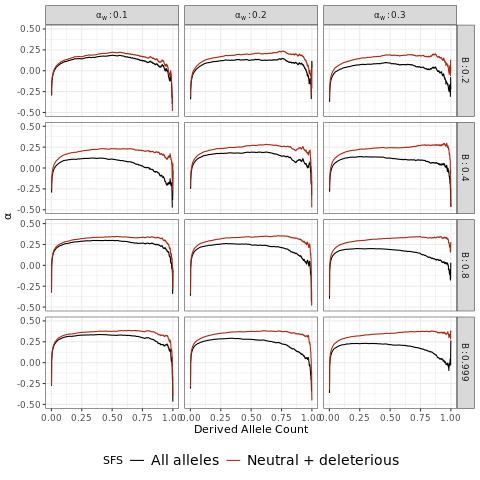

In [54]:
%%R -i PATH -i df_alpha 
p = plot_simulated_alphas(df = df_alpha,output = paste0(PATH,"/results/simulations/slim/isolation/simulated_alphas_dup.svg"))
p = plot_simulated_alphas(df = df_alpha,output = paste0(PATH,"/results/simulations/slim/isolation/simulated_alphas_dup.pdf"))
p = plot_simulated_alphas(df = df_alpha,output = paste0(PATH,"/results/simulations/slim/isolation/simulated_alphas_dup.png"))

p

# Two-epoch model

## Solving fixation probabilites and mutation rate to simulate with MKtest.jl

In [20]:
!julia /home/jmurga/mkt/202004/scripts/src/sim_table.jl 1000 50 200000 twoepochs

In [66]:
sim_table = pd.read_csv(PATH + "/raw_data/simulations/twoepochs.tsv", sep='\t')
sim_table = sim_table[(sim_table.B == 0.4) | (sim_table.B == 0.999)]
sim_table = sim_table[sim_table.alpha_weak == 0.2]
tmp = []
for i in ["bt_moderate","bt_strong","exp_moderate","exp_strong"]:
    x = deepcopy(sim_table)
    x['path'] = x.apply(lambda row: "/home/jmurga/mkt/202004/raw_data/simulations/twoepochs/"+i + "_" + str(row['B']),axis=1)
    tmp.append(x)
    
sim_table = pd.concat(tmp)
sim_table.path.values

array(['/home/jmurga/mkt/202004/raw_data/simulations/twoepochs/bt_moderate_0.4',
       '/home/jmurga/mkt/202004/raw_data/simulations/twoepochs/bt_moderate_0.999',
       '/home/jmurga/mkt/202004/raw_data/simulations/twoepochs/bt_strong_0.4',
       '/home/jmurga/mkt/202004/raw_data/simulations/twoepochs/bt_strong_0.999',
       '/home/jmurga/mkt/202004/raw_data/simulations/twoepochs/exp_moderate_0.4',
       '/home/jmurga/mkt/202004/raw_data/simulations/twoepochs/exp_moderate_0.999',
       '/home/jmurga/mkt/202004/raw_data/simulations/twoepochs/exp_strong_0.4',
       '/home/jmurga/mkt/202004/raw_data/simulations/twoepochs/exp_strong_0.999'],
      dtype=object)

## Running SLiM

We run SLiM into and HPC enviroment due to the amount of replicas. Please copy outputs to the proper path after run the simulations. Here is the SLURM scripts:

#### Exponential growth

```bash
#!/bin/bash

#SBATCH --partition=standard
#SBATCH --job-name=isolation
#SBATCH --time=12:00:00
#SBATCH --mail-type=ALL
#SBATCH --mail-user=jesus.murga@uab.cat
#SBACTH --array=1-50000

DPATH="/xdisk/denard/mig2020/rsgrps/denard"

module load slim
module load parallel

# Each command takes about 12hours to run using this configuration

parallel -j200 -u "slim -d ft=5.0 -d nF={} -d sample_size=50 -d mu=6.37967e-17 -d p=\'${DPATH}/jmurga/simulations/twoepoch_exp/exp_moderate_0.999/\' ${DPATH}/jmurga/src/two_epoch_rescaled.slim" ::: `seq 1 50000`
parallel -j200 -u "slim -d ft=50.0 -d nF={} -d sample_size=50 -d mu=6.37967e-17 -d p=\'${DPATH}/jmurga/simulations/twoepoch_exp/exp_strong_0.999/\' ${DPATH}/jmurga/src/two_epoch_rescaled.slim" ::: `seq 1 50000`

parallel -j200 -u "slim -d ft=5.0 -d nF={} -d sample_size=50 -d mu=6.37967e-7 -d p=\'${DPATH}/jmurga/simulations/twoepoch_exp
twoepoch_exp/exp_moderate_0.4/\' ${DPATH}/jmurga/src/two_epoch_rescaled.slim" ::: `seq 1 50000`
parallel -j200 -u "slim -d ft=50.0 -d nF={} -d sample_size=50 -d mu=6.37967e-7 -d p=\'${DPATH}/jmurga/simulations/twoepoch_exp
twoepoch_exp/exp_strong_0.4/\' ${DPATH}/jmurga/src/two_epoch_rescaled.slim" ::: `seq 1 50000` 
```

#### Bottleneck

```bash
#!/bin/bash

#SBATCH --partition=standard
#SBATCH --job-name=isolation
#SBATCH --time=12:00:00
#SBATCH --mail-type=ALL
#SBATCH --mail-user=jesus.murga@uab.cat
#SBACTH --array=1-50000

DPATH="/xdisk/denard/mig2020/rsgrps/denard"

module load slim
module load parallel

# Each command takes about 12hours to run using this configuration

parallel -j200 -u "slim -d ft=0.2 -d nF={} -d sample_size=50 -d mu=6.37967e-17 -d p=\'${DPATH}/jmurga/simulations/twoepoch_bneck/bt_moderate_0.999/\' ${DPATH}/jmurga/src/two_epoch_rescaled.slim" ::: `seq 1 50000`
parallel -j200 -u "slim -d ft=0.05 -d nF={} -d sample_size=50 -d mu=6.37967e-17 -d p=\'${DPATH}/jmurga/simulations/twoepoch_bneck/bt_strong_0.999/\' ${DPATH}/jmurga/src/two_epoch_rescaled.slim" ::: `seq 1 50000`

parallel -j200 -u "slim -d ft=0.2 -d nF={} -d sample_size=50 -d mu=6.37967e-7 -d p=\'${DPATH}/jmurga/simulations/twoepoch_bneck/bt_moderate_0.4/\' ${DPATH}/jmurga/src/two_epoch_rescaled.slim" ::: `seq 1 50000`
parallel -j200 -u "slim -d ft=0.05 -d nF={} -d sample_size=50 -d mu=6.37967e-7 -d p=\'${DPATH}/jmurga/simulations/twoepoch_bneck/bt_strong_0.4/\' ${DPATH}/jmurga/src/two_epoch_rescaled.slim" ::: `seq 1 50000` 
```

## Processing simulated data

In [62]:
sim_table

,bgs_θ,ppos_l,ppos_h,alpha_weak,alpha,estimation,B,path
4,3.762519e-07,0.007741,0.000207,0.2,0.4,0.29361,0.400,/home/jmurga/mkt/202004/raw_data/simulations/t...
10,4.108304e-10,0.007741,0.000207,0.2,0.4,0.40090,0.999,/home/jmurga/mkt/202004/raw_data/simulations/t...
4,3.762519e-07,0.007741,0.000207,0.2,0.4,0.29361,0.400,/home/jmurga/mkt/202004/raw_data/simulations/t...
10,4.108304e-10,0.007741,0.000207,0.2,0.4,0.40090,0.999,/home/jmurga/mkt/202004/raw_data/simulations/t...
4,3.762519e-07,0.007741,0.000207,0.2,0.4,0.29361,0.400,/home/jmurga/mkt/202004/raw_data/simulations/t...
10,4.108304e-10,0.007741,0.000207,0.2,0.4,0.40090,0.999,/home/jmurga/mkt/202004/raw_data/simulations/t...
4,3.762519e-07,0.007741,0.000207,0.2,0.4,0.29361,0.400,/home/jmurga/mkt/202004/raw_data/simulations/t...
10,4.108304e-10,0.007741,0.000207,0.2,0.4,0.40090,0.999,/home/jmurga/mkt/202004/raw_data/simulations/t...


In [67]:
for index,row in sim_table.iterrows():
    print(row.path)
    parse_and_bootstrap(row.path,50,nthreads=20,replicas=100)

/home/jmurga/mkt/202004/raw_data/simulations/twoepochs/bt_moderate_0.4


100%|████████████████████████████| 100/100 [00:15<00:00,  6.52it/s]


/home/jmurga/mkt/202004/raw_data/simulations/twoepochs/bt_moderate_0.999


100%|████████████████████████████| 100/100 [00:15<00:00,  6.40it/s]


/home/jmurga/mkt/202004/raw_data/simulations/twoepochs/bt_strong_0.4


100%|████████████████████████████| 100/100 [00:15<00:00,  6.29it/s]


/home/jmurga/mkt/202004/raw_data/simulations/twoepochs/bt_strong_0.999


100%|████████████████████████████| 100/100 [00:15<00:00,  6.38it/s]


/home/jmurga/mkt/202004/raw_data/simulations/twoepochs/exp_moderate_0.4


100%|████████████████████████████| 100/100 [00:14<00:00,  6.68it/s]


/home/jmurga/mkt/202004/raw_data/simulations/twoepochs/exp_moderate_0.999


100%|████████████████████████████| 100/100 [00:15<00:00,  6.58it/s]


/home/jmurga/mkt/202004/raw_data/simulations/twoepochs/exp_strong_0.4


100%|████████████████████████████| 100/100 [00:15<00:00,  6.44it/s]


/home/jmurga/mkt/202004/raw_data/simulations/twoepochs/exp_strong_0.999


100%|████████████████████████████| 100/100 [00:15<00:00,  6.66it/s]


In [70]:
df,df_alpha = save_simulated_alphas(sim_table);
df_alpha

,f,alphas,B,alpha_weak,sfs,path
0,0.010101,-0.485812,0.400,0.2,Neutral + deleterious,bt_moderate_0.4
1,0.020202,-0.326769,0.400,0.2,Neutral + deleterious,bt_moderate_0.4
2,0.030303,-0.282312,0.400,0.2,Neutral + deleterious,bt_moderate_0.4
3,0.040404,-0.249439,0.400,0.2,Neutral + deleterious,bt_moderate_0.4
4,0.050505,-0.222291,0.400,0.2,Neutral + deleterious,bt_moderate_0.4
...,...,...,...,...,...,...
94,0.959596,0.138554,0.999,0.2,All alleles,exp_strong_0.999
95,0.969697,0.147619,0.999,0.2,All alleles,exp_strong_0.999
96,0.979798,0.152848,0.999,0.2,All alleles,exp_strong_0.999
97,0.989899,0.089509,0.999,0.2,All alleles,exp_strong_0.999


In [71]:
df = df.round(3)
df_alpha = df_alpha.round(3)

In [42]:
df.to_csv(PATH + '/results/simulations/slim/twoepochs/simulated_alphas.tsv',index=False,sep='\t',header=True)

In [43]:
df_alpha.to_csv(PATH + '/results/simulations/slim/twoepochs/simulated_to_plot_all.tsv',index=False,sep='\t',header=True)